In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(ggplot2)
library(cowplot)
options(repr.matrix.max.rows = 6)
# libraries copied from worksheet regression 1 + some extras

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
# Reading in our dataset:
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")|>
    rename("ID_num" = 1)
# As the whole dataset would be too large to display, we are only displaying the first 10 rows here.
head(tennis, 10)

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID_num,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,2019-M020,Brisbane,Hard,32,A,20181231,293,104542,NA,⋯,51,34,11,11,6,11,239,200,77,691
8,2019-M020,Brisbane,Hard,32,A,20181231,292,200282,7,⋯,39,30,3,9,3,6,31,1298,72,715
9,2019-M020,Brisbane,Hard,32,A,20181231,291,106421,4,⋯,39,27,7,10,2,6,16,1977,240,200


In [3]:
# Selecting only for rows needed in our data analysis:
tennis_smaller <- tennis|>
    select(ID_num,winner_hand,winner_ht,winner_age, winner_rank,surface, loser_hand,loser_ht, loser_age, loser_rank)|>
    mutate(ID_num = as_factor(ID_num), winner_hand = as_factor(winner_hand)) # Mutating ID_num and winner_hand into factor columns.
# Combining winner and loser data into one column:
tennis_pivot <- tennis_smaller |>
    pivot_longer(cols = c("winner_rank", "loser_rank"),
                     names_to = "wol_rank",
                     values_to = "rank") |>
    pivot_longer(cols = c("winner_ht", "loser_ht"),
                     names_to = "wol_height",
                     values_to = "height") |>
    pivot_longer(cols = c("winner_age", "loser_age"),
                     names_to = "wol_age",
                     values_to = "age") |>
    pivot_longer(cols = c("winner_hand", "loser_hand"),
                     names_to = "wol_hand",
                     values_to = "hand")
# Filtering all NA datas, unknown hand and surface
tennis_filtered <- tennis_pivot |>
                    drop_na() |>
                    filter(hand != "U" & surface != "None")
# Groupping by rank, surface, and hand, then finding mean height and age.
tennis_mean <- tennis_filtered|>
    group_by(rank, surface, hand) |>
    summarize(mean_ht = mean(height, na.rm = TRUE), mean_age = mean(age))
head(tennis_mean, 10)

`summarise()` has grouped output by 'rank', 'surface'. You can override using
the `.groups` argument.


rank,surface,hand,mean_ht,mean_age
<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Clay,L,185.3214,29.89190
1,Clay,R,186.9524,29.46990
1,Grass,L,185.5833,30.19199
⋮,⋮,⋮,⋮,⋮
2,Clay,R,185.2842,29.43126
2,Grass,L,185.3600,31.60991
2,Grass,R,186.7907,32.29683


In [4]:
# Splitting our data 75/25 into training and testing data:
tennis_split <- initial_split(tennis_mean, prop = 0.75, strata = rank )
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

head(tennis_training, 10)

rank,surface,hand,mean_ht,mean_age
<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Clay,R,186.9524,29.46990
1,Grass,R,186.3857,30.98807
1,Hard,L,186.3253,29.47728
⋮,⋮,⋮,⋮,⋮
2,Hard,L,185.4474,30.54575
2,Hard,R,186.2174,31.20472
3,Clay,L,191.0000,29.68671


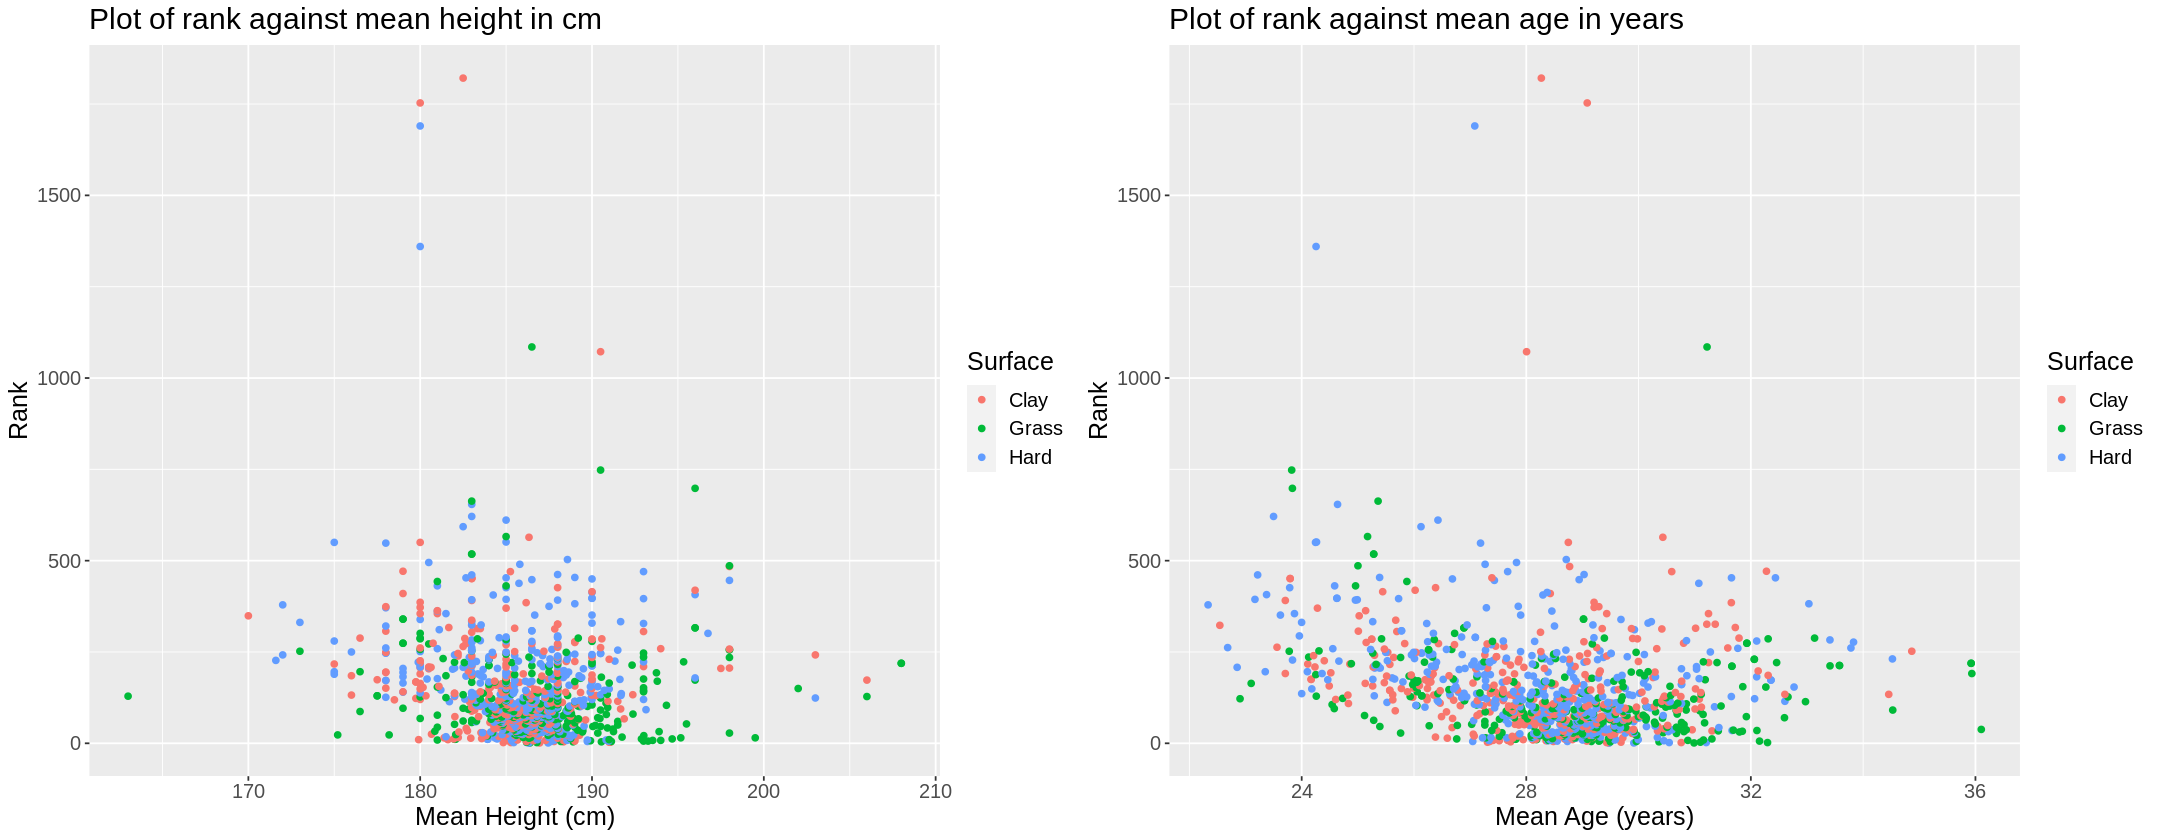

In [5]:
# Plotting rank against mean age:
options(repr.plot.width = 18, repr.plot.height = 7)
rank_vs_age_plot <- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_age, y=rank, color = surface))+
    geom_point() +
    labs(x = "Mean Age (years)", y = "Rank", color = "Surface") +
    ggtitle("Plot of rank against mean age in years")+
    theme(text=element_text(size = 15))

# Plotting height against mean age:
rank_vs_height_plot<- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_ht, y=rank, color = surface))+
    geom_point() +
    labs(x = "Mean Height (cm)", y = "Rank", colour = "Surface") +
    ggtitle("Plot of rank against mean height in cm")+
    theme(text=element_text(size = 15))
# use plot grid
tennis_plots <- plot_grid(rank_vs_height_plot, rank_vs_age_plot)
tennis_plots